- Notebook modified from https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
- Training only, EDA part not included.
- Image model only, tabular data not used.

## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import xgboost as xgb

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os
import time
import pickle

tqdm.pandas()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class Config():
    IMAGE_SIZE = 384
#     BACKBONE = 'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    BACKBONE = 'tf_efficientnet_b0'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 32
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 8
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    
#     MODEL_PATH = '/kaggle/input/plainttraits2024-swintransformer/model.pth'
    MODEL_PATH = '/kaggle/input/planttraits2024-swintransformer-tabular/model.pth'
        
CONFIG = Config()

## Load Data

In [3]:
%%time
read_images = False

if not read_images:
    train = pd.read_pickle('/kaggle/input/plainttraits2024-swintransformer/train.pkl')
    test = pd.read_pickle('/kaggle/input/plainttraits2024-swintransformer/test.pkl')
else: 
    # if CONFIG.TRAIN_MODEL:
    train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
    train['file_path'] = train['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
    train['jpeg_bytes'] = train['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    train.to_pickle('train.pkl')

    test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
    test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')
    test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    test.to_pickle('test.pkl')

for column in CONFIG.TARGET_COLUMNS:
    lower_quantile = train[column].quantile(0.005)
    upper_quantile = train[column].quantile(0.985)  
    train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]    
    
sd_columns = [col for col in train.columns if col.endswith('_sd')]
train = train.drop(columns=sd_columns)
    
CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1    
CONFIG.TABULAR_COLUMNS = train.filter(regex='^(WORLDCLIM_BIO|SOIL|MODIS_2000|VOD)').columns
    
if CONFIG.TRAIN_MODEL:
    print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))
else:
    print('N_TEST_SAMPLES:', len(test))

N_TRAIN_SAMPLES: 49168 N_TEST_SAMPLES: 6545
CPU times: user 1.6 s, sys: 3 s, total: 4.6 s
Wall time: 40.7 s


In [4]:
# extract species
train['species'] = train.groupby(CONFIG.TARGET_COLUMNS).ngroup()
species_counts = train['species'].nunique()

print (f"{species_counts} unique species found in {len(train)} records")


17535 unique species found in 49168 records


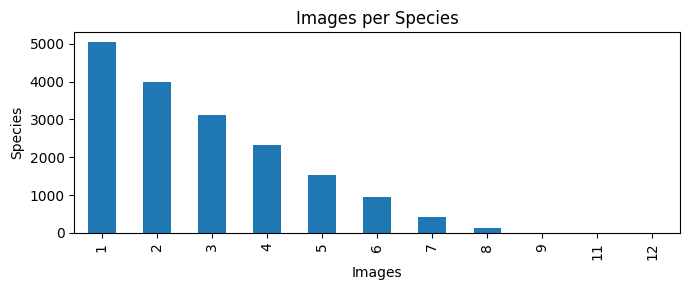

In [5]:
# visualize species
species_count = train['species'].value_counts()
count_summary = species_count.value_counts().sort_index()
count_summary.plot(kind='bar', figsize=(7, 3))

plt.title('Images per Species')
plt.xlabel('Images')
plt.ylabel('Species')

# Show the plot
plt.tight_layout() 
plt.show()

In [6]:
# Make the training set balanced by resampling from the 20,000 plant species
balanced_training = train.copy()

# sample 3 entries from each species column
train = balanced_training.groupby('species').apply(lambda x: x.sample(n=3,replace=True)).reset_index(drop = True) 
print(len(train))


52605


/tmp/ipykernel_24/986111767.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = balanced_training.groupby('species').apply(lambda x: x.sample(n=3,replace=True)).reset_index(drop = True)


In [7]:
# if CONFIG.TRAIN_MODEL:
LOG_FEATURES = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_df = np.zeros_like(train[CONFIG.TARGET_COLUMNS], dtype=np.float32)
for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
    v = train[target].values
    if target in LOG_FEATURES:
        v = np.log10(v)
    y_df[:, target_idx] = v

SCALER = StandardScaler()
y_df = SCALER.fit_transform(y_df)

In [8]:
# Splitting the data into training and validation sets
train_df, val_df, y_train, y_val = train_test_split(train, y_df, test_size=0.2, random_state=42)

In [9]:
# if CONFIG.TRAIN_MODEL:
# LOG_FEATURES_TABULAR = [30, 31, 32, 33, 34, 35, 37, 41, 62, 63, 64, 65, 66, 67, 69, 70, 72, 74, 75, 77, 79, 80, 82, 84, 85, 87, 89, 90, 92, 94, 95, 97, 99, 100, 102, 104, 105, 107, 109, 110, 112, 114, 115, 117, 119, 120, 122, 124, 125]
# LOG_FEATURES_TABULAR = []

# tabular_df_train = np.zeros_like(train_df[CONFIG.TABULAR_COLUMNS], dtype=np.float64)
# tabular_df_val = np.zeros_like(val_df[CONFIG.TABULAR_COLUMNS], dtype=np.float64)
# tabular_df_test = np.zeros_like(test[CONFIG.TABULAR_COLUMNS], dtype=np.float64)

# for tabular_df, df in zip([tabular_df_train, tabular_df_val, tabular_df_test], [train_df, val_df, test]):
#     for col_idx, col in enumerate(CONFIG.TABULAR_COLUMNS):
#         v = df[col].values
#         if col_idx in LOG_FEATURES_TABULAR:
#             v = np.log10(v)
#         tabular_df[:, col_idx] = v 

SCALER_tabular = StandardScaler()
tabular_df_train = SCALER_tabular.fit_transform(train_df[CONFIG.TABULAR_COLUMNS])
tabular_df_val = SCALER_tabular.transform(val_df[CONFIG.TABULAR_COLUMNS])
tabular_df_test = SCALER_tabular.fit_transform(test[CONFIG.TABULAR_COLUMNS])

In [10]:
# for i, col in enumerate(CONFIG.TABULAR_COLUMNS):
#     print(i, col)
#     train[col].plot.hist(bins=12, alpha=0.5)
#     plt.show()
#     plt.hist(tabular_df_train[i], bins=12)
#     plt.show()

In [11]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

TRAIN_TRANSFORMS = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [int(0.85*CONFIG.IMAGE_SIZE), CONFIG.IMAGE_SIZE],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, X_tabular, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.X_tabular = X_tabular
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )
        X_sample['tabular'] = self.X_tabular[index].astype('float32')
        y_sample = self.y[index]
        
        return X_sample, y_sample

if CONFIG.TRAIN_MODEL:
    # Creating datasets for training and validation
    train_dataset = Dataset(
        train_df['jpeg_bytes'].values,
        tabular_df_train,
        y_train,
        TRAIN_TRANSFORMS,
    )

    val_dataset = Dataset(
        val_df['jpeg_bytes'].values,
        tabular_df_val,
        y_val,
        TEST_TRANSFORMS,
    )

    # Creating dataloaders for training and validation
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=False,  # No need to shuffle validation data
        num_workers=psutil.cpu_count(),
    )



test_dataset = Dataset(
    test['jpeg_bytes'].values,
    tabular_df_test,
    test['id'].values,
    TEST_TRANSFORMS,
)

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                pretrained=True,
#                 num_classes=CONFIG.N_TARGETS,
                num_classes=0,
        )
        
        # Freeze the backbone weights
#         for param in self.backbone.parameters():
#             param.requires_grad = False
        
        # EfficientNet = 1280, SwinTrans = 1536, Tabular = 163
        self.custom_layers = nn.Sequential(
            nn.BatchNorm1d(1280+163),
            nn.Linear(1280+163, 512),
            nn.ReLU(), 
            nn.Linear(512, 6)  
        )
        
    def forward(self, inputs):
        image = inputs['image']
        tabular = inputs['tabular']

        x = self.backbone(image)
        x = torch.cat((tabular, x), dim=1)
        x = self.custom_layers(x)
        
        return x


model = Model()
model = model.to(device)
# print(model.backbone.head)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [13]:
create_features = False

if create_features:
    feature_model = torch.load(CONFIG.MODEL_PATH)
    feature_model.backbone.head.fc = nn.Identity()
    feature_model.to(device);

#     dataset = Dataset(
#         train['jpeg_bytes'].values,
#         y_df,
#         TEST_TRANSFORMS,
#     )
    dataset = test_dataset

    # Create a DataLoader for the dataset
    dataloader = DataLoader(dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)

    # Define the shape of the features array
    num_samples = len(dataset)
    num_features = 1536

    # Initialize an empty array filled with zeros to store features
    features_array = np.zeros((num_samples, num_features), dtype=np.float32)

    # Set the model to evaluation mode
    model.eval()

    # Initialize the index counter
    index = 0

    # Iterate over the data loader batches
    for batch in dataloader:
        if index % 10 == 0:
            print(index, end=', ')

        # Extract inputs and labels from the batch
        inputs, _ = batch
        inputs = inputs.to(device)

        # Forward pass through the model to extract features
        with torch.no_grad():
            features = feature_model(inputs)

        # Flatten the features
        features = features.view(features.size(0), -1)

        # Calculate the end index for the current batch
        end_index = index + inputs.size(0)

        # Assign features to the pre-allocated array
        features_array[index:end_index] = features.cpu().numpy()

        # Update the index counter
        index = end_index

    # Save the features as a NumPy array
    np.save('features_test.npy', features_array)
    


In [14]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# # Count parameters
# num_parameters = count_parameters(model)
# print("Number of parameters in the model:", num_parameters)

In [15]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

if CONFIG.TRAIN_MODEL:
    MAE = torchmetrics.regression.MeanAbsoluteError().to(device)
    R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to(device)
    LOSS = AverageMeter()

    Y_MEAN = torch.tensor(y_df).mean(dim=0).to(device)
    EPS = torch.tensor([1e-6]).to(device)

    def r2_loss(y_pred, y_true):
        ss_res = torch.sum((y_true - y_pred)**2, dim=0)
        ss_total = torch.sum((y_true - Y_MEAN)**2, dim=0)
        ss_total = torch.maximum(ss_total, EPS)
        r2 = torch.mean(ss_res / ss_total)
        return r2

    LOSS_FN = r2_loss

    optimizer = torch.optim.AdamW(
        params=model.parameters(),
        lr=CONFIG.LR_MAX,
        weight_decay=CONFIG.WEIGHT_DECAY,
    )

    LR_SCHEDULER = get_lr_scheduler(optimizer)

In [16]:
if CONFIG.TRAIN_MODEL:
    print("Start Training:")
    
    best = float('inf')
    for epoch in range(CONFIG.N_EPOCHS):
        MAE.reset()
        R2.reset()
        LOSS.reset()
        model.train()

        for step, (X_batch, y_true) in enumerate(train_dataloader):
            X_batch['image'] = X_batch['image'].to(device)
            X_batch['tabular'] = X_batch['tabular'].to(device)
            y_true = y_true.to(device)
            t_start = time.perf_counter_ns()
            y_pred = model(X_batch)
            loss = LOSS_FN(y_pred, y_true)
            LOSS.update(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            LR_SCHEDULER.step()
            MAE.update(y_pred, y_true)
            R2.update(y_pred, y_true)

            if not CONFIG.IS_INTERACTIVE and (step+1) == len(train_dataloader):
                print(
                    f'EPOCH {epoch+1:02d}, {step+1:04d}/{len(train_dataloader)} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{len(train_dataloader)} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                    end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
                )
            
        MAE.reset()
        R2.reset()
        LOSS.reset()
        model.eval()
        
        for step, (X_batch, y_true) in enumerate(val_dataloader):
            X_batch['image'] = X_batch['image'].to(device)
            X_batch['tabular'] = X_batch['tabular'].to(device)
            y_true = y_true.to(device)
            t_start = time.perf_counter_ns()
            with torch.no_grad():
                y_pred = model(X_batch)
                loss = LOSS_FN(y_pred, y_true)
                
            LOSS.update(loss)
            MAE.update(y_pred, y_true)
            R2.update(y_pred, y_true)
            if not CONFIG.IS_INTERACTIVE and (step+1) == len(val_dataloader):
                print(
                    f'EPOCH VAL, {epoch+1:02d}, {step+1:04d}/{len(val_dataloader)} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'\rEPOCH VAL {epoch+1:02d}, {step+1:04d}/{len(val_dataloader)} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                    end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
                )
        print()
        if LOSS.avg < best:
            best = LOSS.avg
            torch.save(model, 'model.pth')
            
            
else:
    model = torch.load(CONFIG.MODEL_PATH)
    model.to(device)

Start Training:
EPOCH 01, 1315/1315 | loss: 0.7669, mae: 0.6874, r2: 0.2403, step: 0.715s, lr: 1.00e-04
EPOCH VAL, 01, 0329/329 | loss: 0.6495, mae: 0.6178, r2: 0.3620, step: 0.064s, lr: 1.00e-04

EPOCH 02, 1315/1315 | loss: 0.6242, mae: 0.6101, r2: 0.3856, step: 0.288s, lr: 9.61e-05
EPOCH VAL, 02, 0329/329 | loss: 0.5837, mae: 0.5823, r2: 0.4269, step: 0.057s, lr: 9.61e-05

EPOCH 03, 1315/1315 | loss: 0.5485, mae: 0.5692, r2: 0.4614, step: 0.288s, lr: 8.60e-05
EPOCH VAL, 03, 0329/329 | loss: 0.5495, mae: 0.5634, r2: 0.4627, step: 0.057s, lr: 8.60e-05

EPOCH 04, 1315/1315 | loss: 0.4860, mae: 0.5334, r2: 0.5236, step: 0.288s, lr: 7.09e-05
EPOCH VAL, 04, 0329/329 | loss: 0.5200, mae: 0.5445, r2: 0.4911, step: 0.057s, lr: 7.09e-05

EPOCH 05, 1315/1315 | loss: 0.4299, mae: 0.5005, r2: 0.5798, step: 0.287s, lr: 5.31e-05
EPOCH VAL, 05, 0329/329 | loss: 0.4892, mae: 0.5265, r2: 0.5211, step: 0.057s, lr: 5.31e-05

EPOCH 06, 1315/1315 | loss: 0.3874, mae: 0.4732, r2: 0.6227, step: 0.287s, lr: 

In [17]:
# train_features = np.load('/kaggle/input/planttraits2024-image-features/features_train.npy')
# test_features = np.load('/kaggle/input/planttraits2024-image-features/features_test.npy')

# features_df = pd.DataFrame(train_features)
# features_df.columns = [f'feature_{i}' for i in range(train_features.shape[1])]
# features_df.head()

# train_df = pd.concat([train.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

# features_df = pd.DataFrame(test_features)
# features_df.columns = [f'feature_{i}' for i in range(test_features.shape[1])]
# features_df.head()

# test_df = pd.concat([test.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

In [18]:
# do_cv = True

# remove_cols = [ 
#  'X4_sd',
#  'X11_sd',
#  'X18_sd',
#  'X26_sd',
#  'X50_sd',
#  'X3112_sd',
#  'file_path',
#  'jpeg_bytes'
# ]

# X_full = train_df.drop(columns=CONFIG.TARGET_COLUMNS + remove_cols)
# Y_full = train_df[CONFIG.TARGET_COLUMNS]

In [19]:
# class CustomDataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = torch.tensor(X.values, dtype=torch.float32)
#         self.Y = torch.tensor(Y.values, dtype=torch.long)

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.Y[idx]
    
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return out

In [20]:
# models = {}

# xboost = False
    
# if xboost:
#     for column in Y_full.columns:

#         model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.1, max_depth=10)

#         if do_cv:
#             print(f"\nDoing cross-validation scoring for {column}...")
#             scores = cross_val_score(model, X_full, Y_full[column],
#                                      cv=KFold(n_splits=3, shuffle=True, random_state=42),
#                                      scoring='r2')        
#             print(f"R^2 score for {column}: {np.mean(scores)}")

#         #train model with all data
#         print(f"Training model for {column}...")
#         model.fit(X_full, Y_full[column])
#         models[column] = model

#     with open('all_models.pkl', 'wb') as file:
#         pickle.dump(models, file)
        
#     # with open('all_models.pkl', 'rb') as file:
#     # models = pickle.load(file)
        
# else:
#     X_train, X_val, Y_train, Y_val = train_test_split(X_full, Y_full, test_size=0.2, random_state=42)

#     # Define your datasets for train and validation
#     train_dataset = CustomDataset(X_train, Y_train)
#     val_dataset = CustomDataset(X_val, Y_val)

#     # Define your data loaders for train and validation
#     train_dataloader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
#     val_dataloader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)
#     model = NeuralNetwork(1700, 512, 6)
    
   

In [21]:
# mean_values = Y_full.mean()
# submission = pd.DataFrame({'id': test_df['id']})
# submission[Y_full.columns] = mean_values

# #rename from _mean
# submission.columns = submission.columns.str.replace('_mean', '')
# submission

In [22]:
# remove_cols = [ 
#  'file_path',
#  'jpeg_bytes'
# ]

# X_test = test_df.drop(columns=remove_cols)

# submission['X4'] = models['X4_mean'].predict(X_test)
# submission['X11'] = models['X11_mean'].predict(X_test)
# submission['X18'] = models['X18_mean'].predict(X_test)
# submission['X50'] = models['X50_mean'].predict(X_test)
# submission['X26'] = models['X26_mean'].predict(X_test)
# submission['X3112'] = models['X3112_mean'].predict(X_test)

# submission

In [23]:
# submission.to_csv('submission.csv', index=False)

In [24]:
model = torch.load('/kaggle/working/model.pth')
model.to(device);

In [25]:
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataset):
    X_sample_test['image'] = torch.Tensor(X_sample_test['image']).unsqueeze(0).to(device)
    X_sample_test['tabular'] = torch.Tensor(X_sample_test['tabular']).unsqueeze(0).to(device)
    with torch.no_grad():
        y_pred = model(X_sample_test).detach().cpu().numpy()
    
    y_pred = SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
        if k in LOG_FEATURES:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df.to_csv('submission.csv', index=False)
print("Submit!")

  0%|          | 0/6545 [00:00<?, ?it/s]

Submit!
